<a href="https://colab.research.google.com/github/khalidmeister/trmm-downscaling/blob/main/code_downscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
! pip install geopandas
! pip install geojson
! pip install fiona
! pip install georasters

import fiona
import geojson
import folium
import ee
import numpy as np
import geopandas as gpd
import georasters as gr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

ee.Authenticate()
ee.Initialize()

     |████████████████████████████████| 1.0MB 6.6MB/s 
     |████████████████████████████████| 6.5MB 15.2MB/s 
     |████████████████████████████████| 15.3MB 256kB/s 
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=gpq7U80yP7til20z36jC0hCC1bQqSnqHJcVCwsIk-Ck&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5vvtfEYt9g6q3nKg7n27BhgvaEjrscrrFcLKsrz9KenoebmTxHRnQ

Successfully saved authorization token.


# Helper Function

In [3]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Area of Interest

## Point of Interest

In [7]:
# Pekanbaru
lat = 0.511189523538957 
lon = 101.44666084225209
poi = ee.Geometry.Point(lon, lat)

# # Singapore
# lat = 1.4311524391271884 
# lon = 103.91858465490296

## Region of Interest

In [8]:
! wget https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip
! unzip gadm36_IDN_shp.zip
! ls

--2021-04-26 05:10:11--  https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip
Resolving biogeo.ucdavis.edu (biogeo.ucdavis.edu)... 128.120.228.172
Connecting to biogeo.ucdavis.edu (biogeo.ucdavis.edu)|128.120.228.172|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip [following]
--2021-04-26 05:10:11--  https://data.biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip
Resolving data.biogeo.ucdavis.edu (data.biogeo.ucdavis.edu)... 128.120.228.172
Connecting to data.biogeo.ucdavis.edu (data.biogeo.ucdavis.edu)|128.120.228.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161235162 (154M) [application/zip]
Saving to: ‘gadm36_IDN_shp.zip’

gadm36_IDN_shp.zip  100%[===================>] 153.77M  36.5MB/s    in 4.5s    

2021-04-26 05:10:16 (34.5 MB/s) - ‘gadm36_IDN_shp.zip’ saved [161235162/161235162]

Archive:  gadm36_IDN_shp.zip
 extracting: gadm36_IDN_1.

In [9]:
prov = gpd.read_file('gadm36_IDN_1.shp')
riau = prov[prov['NAME_1'] == 'Riau'] 
riau

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
23,IDN,Indonesia,IDN.24_1,Riau,None,None,Propinisi,Province,14,ID.RI,"MULTIPOLYGON (((103.41634 -0.67546, 103.41668 ..."


In [10]:
riau.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

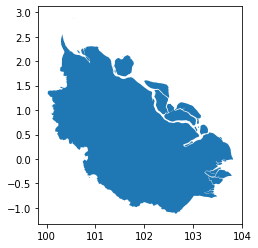

In [11]:
riau.plot()

### Finding Minimum Bounding Box

In [ ]:
riau.to_file('riau.shp')

In [ ]:
# Get minimum bounding rectangle
shp =  fiona.open('riau.shp')
shp.bounds

(100.02484894, -1.12227285, 103.81461334, 2.91912794)

In [ ]:
riau_bounding_box = ee.Geometry.Rectangle([100.02484894, -1.12227285, 103.81461334, 2.91912794])

### Get The Region to GeoJSON

In [12]:
riau.to_file('riau.geojson', driver='GeoJSON')

In [13]:
with open('riau.geojson') as f:
  riau_geojson = geojson.load(f)

riau_geojson = ee.Geometry(riau_geojson['features'][0]['geometry'])

In [100]:
print(riau_geojson.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


# Satellite

## Precipitation from TRMM

In [123]:
# Import the satellite images
trmm = ee.ImageCollection('TRMM/3B43V7')
# Select the band
trmm = trmm.select('precipitation')
# Filter the date
trmm = trmm.filterDate('2018-01-01', '2018-12-31')
# Reduce the TRMM and Reproject Them
trmm_img = trmm.reduce(ee.Reducer.mean())
# Reproject with original resolution
trmm_img = trmm_img.reproject(crs=riau_geojson.projection(), scale=25000)
# Clip the Image
trmm_img = trmm_img.clip(riau_geojson)
# Params for Visualization
trmm_params = {
    'min':0.1, 'max':1.2, 'region': riau_geojson, 'dimension':512,
    'palette': ['blue', 'yellow', 'orange', 'red']
}

## Digital Elevation Model from STRM

In [133]:
# Get the satellite images
srtm = ee.Image('CGIAR/SRTM90_V4')
# Select the band
elevation = srtm.select('elevation')
# Get the slope from the band
slope = ee.Terrain.slope(elevation)
# Reproject the Map
slope_ori = slope.reproject(crs=riau_geojson.projection(), scale=90)
# Clip the image
slope_ori = slope_ori.clip(riau_geojson)
# Params for Visualization
slope_params = {
    'min':0, 
    'max':60
}

## NDVI from MODIS

In [134]:
# Select the satellite images
modis = ee.ImageCollection('MODIS/006/MOD13A2')
# Select the band
ndvi = modis.select('NDVI')
# Retrieve the first image
ndvi = ndvi.filterDate('2018-01-01', '2018-12-31')
# Get the annual NDVI and Reproject the Map
ndvi = ndvi.reduce(ee.Reducer.mean())
# Reproject with original scale
ndvi_ori = ndvi.reproject(crs=riau_geojson.projection(), scale=1000)
# Clip the Image
ndvi_ori = ndvi_ori.clip(riau_geojson)
# Params for visualization
ndvi_params = {
  'min': 0.0,
  'max': 9000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

## Land Cover from MODIS

In [135]:
modis = ee.ImageCollection('MODIS/006/MCD12Q1')
lc = modis.select('LC_Type1')
lc = lc.filterDate('2018-01-01', '2018-05-31').first()
lc_ori = lc.reproject(crs=riau_geojson.projection(), scale=500) 
lc_ori = lc_ori.clip(riau_geojson)
lc_params = {
  'min': 1.0,
  'max': 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
  ],
}

# Visualization

In [136]:
my_map = folium.Map(location=[lat, lon], zoom_start=8)
my_map.add_ee_layer(trmm_img, trmm_params, 'Precipitation from TRMM')
my_map.add_ee_layer(trmm.first().reproject(crs=riau_geojson.projection(), scale=25000).clip(riau_geojson), trmm_params, 'Precipitation from TRMM (Jan \'18)')
my_map.add_ee_layer(slope_ori, slope_params, 'SRTM Digital Elevation Model')
my_map.add_ee_layer(ndvi_ori, ndvi_params, 'NDVI from MODIS')
my_map.add_ee_layer(lc_ori, lc_params, 'Land Cover from MODIS')
folium.LayerControl().add_to(my_map)
display(my_map)

In [137]:
print(trmm_img.projection().getInfo())
print(slope_ori.projection().getInfo())
print(ndvi_ori.projection().getInfo())
print(lc_ori.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.22457882102988036, 0, 0, 0, -0.22457882102988036, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0008084837557075694, 0, 0, 0, -0.0008084837557075694, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.008983152841195215, 0, 0, 0, -0.008983152841195215, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.004491576420597608, 0, 0, 0, -0.004491576420597608, 0]}


# Resample and Reproject The Images

## 25 KM

In [182]:
ndvi_25km = ndvi.reproject(crs=riau_geojson.projection(), scale=25000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
slope_25km = slope.reproject(crs=riau_geojson.projection(), scale=25000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
lc_25km = lc.reproject(crs=riau_geojson.projection(), scale=25000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)

ndvi_25km = ndvi_25km.clip(riau_geojson)
slope_25km = slope_25km.clip(riau_geojson)
lc_25km = lc_25km.clip(riau_geojson)

ndvi_params = {
  'min': 0.0,
  'max': 9000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

slope_params = {
    'min':0, 
    'max':60
}

lc_params = {
  'min': 1.0,
  'max': 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
  ],
}

my_map = folium.Map(location=[lat, lon], zoom_start=8)
my_map.add_ee_layer(trmm_img, trmm_params, 'Precipitation from TRMM')
my_map.add_ee_layer(ndvi_resample, ndvi_params, 'NDVI from MODIS')
my_map.add_ee_layer(slope_resample, slope_params, 'DEM from SRTM')
my_map.add_ee_layer(lc_resample, lc_params, 'LC from MODIS')
folium.LayerControl().add_to(my_map)
display(my_map)

## 1 KM

In [169]:
# Rescale from origin scale => 1x1KM
ndvi_1km = ndvi.reproject(crs=riau_geojson.projection(), scale=1000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
slope_1km = slope.reproject(crs=riau_geojson.projection(), scale=1000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
lc_1km = lc.reproject(crs=riau_geojson.projection(), scale=1000).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)

# Focus on the Region of Interest
ndvi_1km = ndvi_1km.clip(riau_geojson)
slope_1km = slope_1km.clip(riau_geojson)
lc_1km = lc_1km.clip(riau_geojson)

ndvi_params = {
  'min': 0.0,
  'max': 9000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

slope_params = {
    'min':0, 
    'max':60
}

lc_params = {
  'min': 1.0,
  'max': 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
  ],
}

my_map = folium.Map(location=[lat, lon], zoom_start=8)
my_map.add_ee_layer(ndvi_1km, ndvi_params, 'NDVI from MODIS')
my_map.add_ee_layer(slope_1km, slope_params, 'DEM from SRTM')
my_map.add_ee_layer(lc_1km, lc_params, 'LC from MODIS')
folium.LayerControl().add_to(my_map)
display(my_map)

# Projection Information

In [170]:
print("Original Projection")
print(trmm_img.projection().getInfo())
print(ndvi_ori.projection().getInfo())
print(slope_ori.projection().getInfo())
print(lc_ori.projection().getInfo())
print()
print("New Projection: 25KM")
print(ndvi_25km.projection().getInfo())
print(slope_25km.projection().getInfo())
print(lc_25km.projection().getInfo())
print("New Projection: 1KM")
print(ndvi_1km.projection().getInfo())
print(slope_1km.projection().getInfo())
print(lc_1km.projection().getInfo())

Original Projection
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.22457882102988036, 0, 0, 0, -0.22457882102988036, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.008983152841195215, 0, 0, 0, -0.008983152841195215, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0008084837557075694, 0, 0, 0, -0.0008084837557075694, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.004491576420597608, 0, 0, 0, -0.004491576420597608, 0]}

New Projection: 25KM
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.22457882102988036, 0, 0, 0, -0.22457882102988036, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.22457882102988036, 0, 0, 0, -0.22457882102988036, 0]}
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.22457882102988036, 0, 0, 0, -0.22457882102988036, 0]}
New Projection: 1KM
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.008983152841195215, 0, 0, 0, -0.008983152841195215, 0]}
{'type': 'Projection', '

# Save the Satellite Images

## TRMM

In [143]:
task = ee.batch.Export.image.toDrive(
    image=trmm_img,
    description='trmm_25km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619422486774,
 'description': 'trmm_25km',
 'id': 'UJCDYO2Z42DHGUOFR322SESS',
 'name': 'projects/earthengine-legacy/operations/UJCDYO2Z42DHGUOFR322SESS',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619422486774}

## NDVI

In [171]:
task = ee.batch.Export.image.toDrive(
    image=ndvi_25km,
    description='ndvi_25km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619423224562,
 'description': 'ndvi_25km',
 'id': '3XN76FCOJPMV2EASTSN6Z2OG',
 'name': 'projects/earthengine-legacy/operations/3XN76FCOJPMV2EASTSN6Z2OG',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619423224562}

In [148]:
task = ee.batch.Export.image.toDrive(
    image=ndvi_1km,
    description='ndvi_1km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619422577978,
 'description': 'ndvi_1km',
 'id': 'AB3GJTBGBPNIFK6NGY5Z3HRJ',
 'name': 'projects/earthengine-legacy/operations/AB3GJTBGBPNIFK6NGY5Z3HRJ',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619422577978}

## DEM

In [172]:
task = ee.batch.Export.image.toDrive(
    image=slope_25km,
    description='dem_25km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619423230131,
 'description': 'dem_25km',
 'id': '5NNMVYI3UMJRFDEEXHZXDNX5',
 'name': 'projects/earthengine-legacy/operations/5NNMVYI3UMJRFDEEXHZXDNX5',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619423230131}

In [154]:
task = ee.batch.Export.image.toDrive(
    image=slope_1km,
    description='dem_1km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619422690068,
 'description': 'dem_1km',
 'id': 'NMKDX6LNA7N6WEIWMWZL2422',
 'name': 'projects/earthengine-legacy/operations/NMKDX6LNA7N6WEIWMWZL2422',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619422690068}

## Land Cover

In [183]:
task = ee.batch.Export.image.toDrive(
    image=lc_25km,
    description='lc_25km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619423402777,
 'description': 'lc_25km',
 'id': 'A4OCK37TYJGQM57ZJ3EZDS5X',
 'name': 'projects/earthengine-legacy/operations/A4OCK37TYJGQM57ZJ3EZDS5X',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619423402777}

In [162]:
task = ee.batch.Export.image.toDrive(
    image=lc_1km,
    description='lc_1km',
    folder='spatial-downscaling-trmm',
    region=riau_geojson,
    fileFormat='GeoTIFF'
)

task.start()
task.status()

{'creation_timestamp_ms': 1619422857655,
 'description': 'lc_1km',
 'id': 'APQFJG5MO5ZOCIGUO3V3LFWR',
 'name': 'projects/earthengine-legacy/operations/APQFJG5MO5ZOCIGUO3V3LFWR',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1619422857655}

# Build The Machine Learning Model

In [223]:
trmm_25km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/trmm_25km.tif')
ndvi_25km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/ndvi_25km.tif')
dem_25km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/dem_25km.tif')
lc_25km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/lc_25km.tif')

## Visualize the satellite images

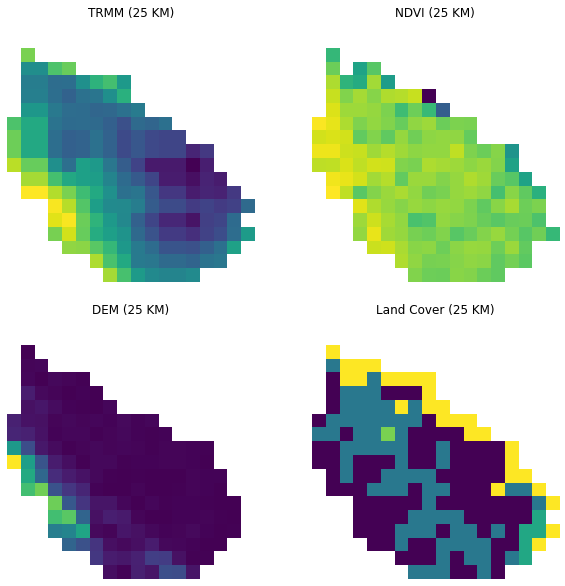

In [224]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].matshow(trmm_25km.raster)
ax[0, 0].set_title('TRMM (25 KM)')
ax[0, 0].axis('off')
ax[0, 1].matshow(ndvi_25km.raster)
ax[0, 1].set_title('NDVI (25 KM)')
ax[0, 1].axis('off')
ax[1, 0].matshow(dem_25km.raster)
ax[1, 0].set_title('DEM (25 KM)')
ax[1, 0].axis('off')
ax[1, 1].matshow(lc_25km.raster)
ax[1, 1].set_title('Land Cover (25 KM)')
ax[1, 1].axis('off')
plt.show()

## Prepare The Dataframe

In [243]:
def prepare_df(data, colnames):
  df = data.to_pandas()
  df = df.drop(['x', 'y'], axis=1)
  df.columns = ['row', 'col', colnames]
  df['coordinates'] = df['row'].astype('str') + df['col'].astype('str')
  df = df.drop(['row', 'col'], axis=1)
  return df

In [260]:
ndvi_df = prepare_df(ndvi_25km, 'ndvi')
dem_df = prepare_df(dem_25km, 'dem')
lc_df = prepare_df(lc_25km, 'land_cover')
trmm_df = prepare_df(trmm_25km, 'precipitation')

In [261]:
final_df = trmm_df.merge(lc_df, on='coordinates').merge(ndvi_df, on='coordinates').merge(dem_df, on='coordinates')
print(final_df.shape)
final_df.head()

(173, 5)


,precipitation,coordinates,land_cover,ndvi,dem
0,0.353415,11,17.0,5348.822964,0.006042
1,0.300940,21,8.0,6153.956522,0.016921
2,0.289074,31,2.0,6908.739130,0.025218
3,0.289074,32,17.0,5233.732372,0.002702
4,0.277604,33,17.0,4966.967133,0.027595


## Data Exploration

In [208]:
for i in [trmm_25km, ndvi_25km, dem_25km, lc_25km]:
  print(i.raster.shape)
  df = i.to_pandas()
  print(df.shape)
  print(df['row'].min(), df['col'].min())
  print(df['row'].max(), df['col'].max())
  print()

(18, 18)
(190, 5)
1 0
17 17

(18, 18)
(183, 5)
1 0
17 17

(18, 18)
(174, 5)
1 0
17 16

(18, 18)
(190, 5)
1 0
17 17



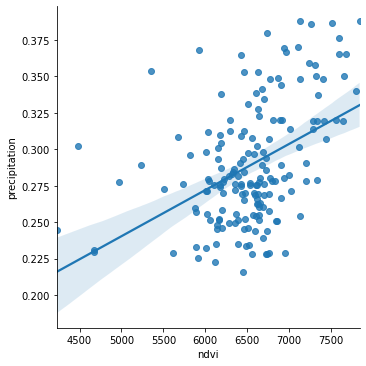

In [277]:
import seaborn as sns
sns.lmplot(data=final_df, x='ndvi', y='precipitation')
plt.show()

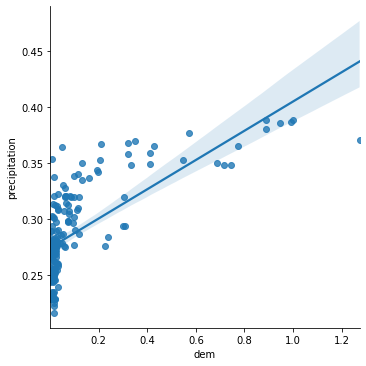

In [278]:
sns.lmplot(data=final_df, x='dem', y='precipitation')
plt.show()

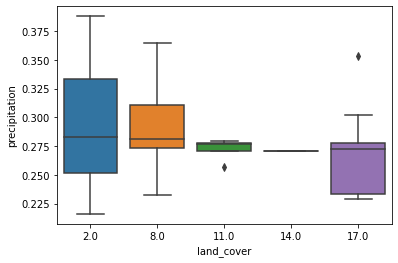

In [280]:
sns.boxplot(data=final_df, x='land_cover', y='precipitation')
plt.show()

## Preprocessing for modelling

In [ ]:
from sklearn.preprocessing import StandardScaler

X = final_df[['ndvi', 'dem', 'land_cover']].values
y = final_df[['precipitation']].values


# Downscale the Image

In [266]:
ndvi_1km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/ndvi_1km.tif')
dem_1km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/dem_1km.tif')
lc_1km = gr.from_file('/content/drive/MyDrive/spatial-downscaling-trmm/lc_1km.tif')

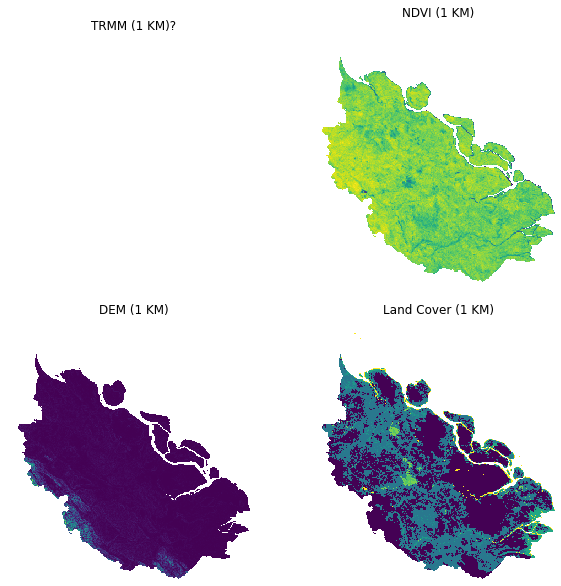

In [268]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax[0, 0].matshow(trmm_1km.raster)
ax[0, 0].set_title('TRMM (1 KM)?')
ax[0, 0].axis('off')
ax[0, 1].matshow(ndvi_1km.raster)
ax[0, 1].set_title('NDVI (1 KM)')
ax[0, 1].axis('off')
ax[1, 0].matshow(dem_1km.raster)
ax[1, 0].set_title('DEM (1 KM)')
ax[1, 0].axis('off')
ax[1, 1].matshow(lc_1km.raster)
ax[1, 1].set_title('Land Cover (1 KM)')
ax[1, 1].axis('off')
plt.show()

# Playground

In [ ]:
ts = pd.DataFrame(trmm.getRegion(poi, 1000).getInfo(), columns =['id', 'longitude',	'latitude',	'time',	'precipitation']).drop(0)
ts['new_time'] = pd.to_datetime(ts['time'], unit='ms')
ts

,id,longitude,latitude,time,precipitation,new_time
1,3B43_20180101_7,101.442,0.507548,1514764800000,0.140614,2018-01-01
2,3B43_20180201_7,101.442,0.507548,1517443200000,0.237015,2018-02-01
3,3B43_20180301_7,101.442,0.507548,1519862400000,0.452564,2018-03-01
4,3B43_20180401_7,101.442,0.507548,1522540800000,0.260523,2018-04-01
5,3B43_20180501_7,101.442,0.507548,1525132800000,0.275634,2018-05-01
6,3B43_20180601_7,101.442,0.507548,1527811200000,0.330823,2018-06-01
7,3B43_20180701_7,101.442,0.507548,1530403200000,0.185985,2018-07-01
8,3B43_20180801_7,101.442,0.507548,1533081600000,0.167527,2018-08-01
9,3B43_20180901_7,101.442,0.507548,1535760000000,0.158032,2018-09-01
10,3B43_20181001_7,101.442,0.507548,1538352000000,0.519063,2018-10-01
